In [2]:
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q -U einops
!pip install -q -U safetensors
!pip install -q -U torch
!pip install -q -U xformers
!pip install -q -U langchain
!pip install -q -U ctransformers[cuda]
!pip install chromadb
!pip install sentence-transformers
!pip install faiss-gpu`

## Import the required libraries

In [1]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [2]:
import torch
from transformers import BitsAndBytesConfig
from langchain import HuggingFacePipeline
from langchain import PromptTemplate, LLMChain
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from langchain_core.prompts import FewShotPromptTemplate, PromptTemplate
import faiss
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain_community.vectorstores import FAISS
from langchain_core.example_selectors import SemanticSimilarityExampleSelector
# from langchain_openai import OpenAIEmbeddings

# Connect CSV to SQLite DB

In [3]:
# Connection details
database_file = "database_LLM.db"  # Replace with your database filename

# Read the CSV
df = pd.read_csv("Data/LLM_data.csv")  # Replace with your CSV filename
df['DemandDate'] = pd.to_datetime(df['DemandDate'], format='%m/%d/%y')

# Connect to the SQLite database
conn = sqlite3.connect(database_file)

# Transfer the DataFrame to a table (replace 'your_table_name' accordingly)
df.to_sql("LLM_sql", conn, if_exists="replace", index=False)

# Close the connection
conn.close()

## Load the model and create the LLM chain

In [62]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
)

model_id = "mistralai/Mistral-7B-Instruct-v0.1"

from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
model_4bit = AutoModelForCausalLM.from_pretrained( model_id, device_map="auto",quantization_config=quantization_config, )
tokenizer = AutoTokenizer.from_pretrained(model_id)


from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
pipeline = pipeline(
        "text-generation",
        model=model_4bit,
        tokenizer=tokenizer,
        use_cache=True,
        device_map="auto",
        max_length=500,
        do_sample=True,
        top_k=5,
        num_return_sequences=1,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id,
)

llm = HuggingFacePipeline(pipeline=pipeline)

/usr/local/lib/python3.10/dist-packages/accelerate/utils/modeling.py:1341: UserWarning: Current model requires 100664064.0 bytes of buffer for offloaded layers, which seems does not fit any GPU's remaining memory. If you are experiencing a OOM later, please consider using offload_buffers=True.
  warnings.warn(


ValueError: 
                    Some modules are dispatched on the CPU or the disk. Make sure you have enough GPU RAM to fit the
                    quantized model. If you want to dispatch the model on the CPU or the disk while keeping these modules
                    in 32-bit, you need to set `load_in_8bit_fp32_cpu_offload=True` and pass a custom `device_map` to
                    `from_pretrained`. Check
                    https://huggingface.co/docs/transformers/main/en/main_classes/quantization#offload-between-cpu-and-gpu
                    for more details.
                    

## Define the prompt and create the LLM chain

In [53]:
template="""<s>[INST] You are a helpful, respectful and honest SQLlite assistant. Return the appropriate SQLlite query given the table and its respective schema as below:

table name : LLM_sql
Column names : PartID, RepairID, CarID, DemandDate, Quantity, ModelYear.
Here is the description of each column:
PartID: Unique identifier for each part.(Character)
RepairID: Unique identifier for each repair instance. It has only one record (Alphanumeric)
CarID: Unique identifier for cars; .(Alphanumeric)
DemandDate: Date of repair demand ((datetime) format)
Quantity: Number of parts used or required for the repair.(Integer)
ModelYear: Year the car model was manufactured.(Integer)


For the given question: {question}
Follow the following guidelines:
1.If the question mentions just year but not model year, then strictly consider extracting  information from DemandDate.
2.If not explicitly mentioned, write the sqlite query for fetching all the rows, dont use limit.
3.Opt for a easier route to handle the question than going for subqueries
4. Since it is sqlite, year(),month(),day() methods are not to be used, use strftime function
Write the SQLite3 query and dont give any other description: [/INST] </s>
"""

prompt_init = PromptTemplate(template=template, input_variables=["question"])


# Define the LLM chain
llm_chain = LLMChain(prompt=prompt_init,llm=llm)



## SQL Query generation

In [54]:
def generate_response(question,llm_chain):
  response = llm_chain.run({"question":question})

  return response

## Querying the table basis the sql query generated

In [55]:
def query_table(sql_response):
  check_words = ['plots', 'trends','plot','trend','graphs', 'graph']

  conn = sqlite3.connect('database_LLM.db')
  cursor = conn.cursor()

  df = pd.read_sql_query(sql_response, conn)

  if any(sub in question for sub in check_words):
    # Plotting
    plt.plot(df.iloc[:, 0], df.iloc[:, 1], marker='o')  # 'o' for markers at data points
    plt.xlabel(df.columns[0])  # Assigning column name as x-axis label
    plt.ylabel(df.columns[1])  # Assigning column name as y-axis label
    plt.title('Plot Title')
    plt.grid(True)  # Add grid lines
    plt.show()

  conn.close()

  return df

## Output

### Query1 : Which model year had the highest quantity consumed in 2023?

In [36]:
question="Which model year had the highest quantity consumed in 2023?"

response=generate_response(question,llm_chain)
print(response)

In [62]:
response_sqlite="SELECT ModelYear, SUM(Quantity) AS TotalQuantity FROM LLM_sql\nWHERE strftime('%Y', DemandDate) = '2023'\nGROUP BY ModelYear\nORDER BY TotalQuantity DESC\nLIMIT 1;"

In [63]:
query_table(response_sqlite)

,ModelYear,TotalQuantity
0,2015.0,10213


### Query2 : How many cars have undergone multiple repairs?

In [86]:
question="How many cars have undergone multiple repairs?"

response=generate_response(question,llm_chain)
print(response)

```sql
SELECT DISTINCT(CarID)
FROM LLM_sql
WHERE CarID IN (
SELECT CarID
FROM LLM_sql
GROUP BY CarID
HAVING COUNT(*) > 1
)
ORDER BY CarID;
```


In [80]:
response_sqlite="""SELECT DISTINCT carid
FROM LLM_sql
WHERE RepairID IN (SELECT RepairID
                   FROM LLM_sql
                   GROUP BY CarID
                   HAVING COUNT(*) > 1);"""
query_table(response_sqlite)

,CarID
0,43a9da48ae050ece5b577ecca6daae5c
1,2dd9b192dae6a476a606e59d53b12dad
2,bc227b357aa2afd31409c53e6efd9a22
3,1740179fa9fed9819a86998ea46da0a1
4,5803c0cda7dc24f46a9a1a79abbc70fb
...,...
56077,02d47e002059e63f1872a9b1bc063bfe
56078,398183c5acf1a20c14a28e2b6fcf4e53
56079,72e15d3fa3e17fe7324483f1dbf484d5
56080,efd758d46f3e75f6bd7a98ae97e7904c


### Query3 : "Calculate the number of unique repairs that occur each year and plot the trend?"

In [85]:
question="Calculate the number of unique repairs that occur each year and plot the trend?"

response=generate_response(question,llm_chain)
print(response)

```sql
SELECT YEAR(DemandDate) AS Year, COUNT(DISTINCT RepairID) AS UniqueRepairs
FROM LLM_sql
GROUP BY Year;
```
This query will give you the number of unique repairs that occur each year. The `YEAR()` function is used to extract the year from the `DemandDate` column and `COUNT(DISTINCT RepairID)` is used to count the number of unique repairs for each year.


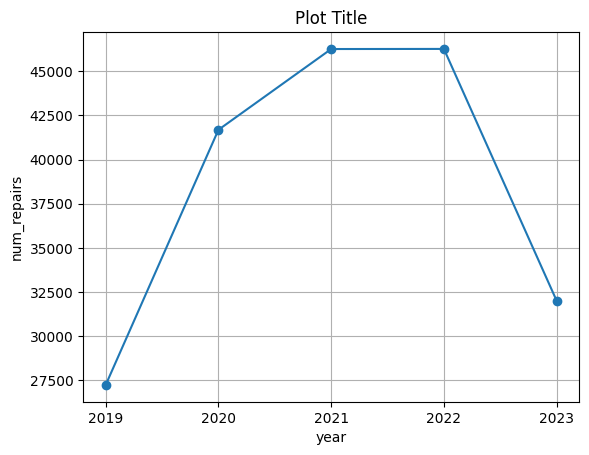

,year,num_repairs,num_parts
0,2019,27238,4
1,2020,41682,3
2,2021,46255,4
3,2022,46261,4
4,2023,32007,3


In [82]:
response_sqlite="""SELECT
    strftime('%Y', DemandDate) AS year,
    COUNT(DISTINCT RepairID) AS num_repairs,
    COUNT(DISTINCT PartID) AS num_parts
FROM LLM_sql
GROUP BY strftime('%Y', DemandDate)
ORDER BY strftime('%Y', DemandDate)
"""
query_table(response_sqlite)

#### Query 4 : What is the earliest demand date for each model year?

In [87]:
question="What is the earliest demand date for each model year?"

response=generate_response(question,llm_chain)
print(response)

SELECT ModelYear, MIN(DemandDate) FROM LLM_sql GROUP BY ModelYear;


In [88]:
response_sqlite=response
query_table(response_sqlite)

,ModelYear,MIN(DemandDate)
0,NaN,2019-01-03 00:00:00
1,2012.0,2019-01-03 00:00:00
2,2013.0,2019-01-01 00:00:00
3,2014.0,2019-01-01 00:00:00
4,2015.0,2019-01-01 00:00:00
5,2016.0,2019-01-01 00:00:00
6,2017.0,2019-01-01 00:00:00
7,2018.0,2019-01-01 00:00:00
8,2019.0,2019-02-08 00:00:00
9,2020.0,2019-11-15 00:00:00


#### Query 5 : Which months of the year tend to have the most repairs?

In [96]:
question="Which months of the year tend to have the most repairs?"

response=generate_response(question,llm_chain)
print(response)

```
SELECT MONTH(DemandDate), 
       SUM(Quantity) AS TotalRepairs
FROM LLM_sql
GROUP BY MONTH(DemandDate)
ORDER BY TotalRepairs DESC
LIMIT 12;
```


In [100]:
response_sqlite="""SELECT strftime('%m', DemandDate) as Month,
       SUM(Quantity) AS TotalRepairs
FROM LLM_sql
GROUP BY strftime('%m', DemandDate)
ORDER BY TotalRepairs DESC
LIMIT 12;
"""
query_table(response_sqlite)

,Month,TotalRepairs
0,01,22385
1,03,20162
2,02,19092
3,12,18219
4,05,16988
5,04,16882
6,06,16679
7,08,16402
8,09,16316
9,11,16289


#### Query 6 : Calculate the total quantity of parts used for repairs requested in each year ?

In [72]:
question=" Calculate the total quantity of parts used for repairs requested in each year?"

response=generate_response(question,llm_chain)
print(response)


```
SELECT strftime('%Y', DemandDate) AS Year, SUM(Quantity)
FROM LLM_sql
GROUP BY Year
```


In [73]:
response_sqlite="""SELECT strftime('%Y', DemandDate) AS Year, SUM(Quantity)
FROM LLM_sql
GROUP BY Year;
"""
query_table(response_sqlite)

,Year,SUM(Quantity)
0,2019,30267
1,2020,45439
2,2021,50241
3,2022,50480
4,2023,34957


#### Query 7 : Retrieve the top 5 car models with the highest total quantity of parts used for repairs:  

In [74]:
question="Retrieve the top 5 car models with the highest total quantity of parts used for repairs?"

response=generate_response(question,llm_chain)
print(response)


```sql
SELECT ModelYear, SUM(Quantity) AS TotalQuantity
FROM LLM_sql
GROUP BY ModelYear
ORDER BY TotalQuantity DESC
LIMIT 5
```


In [75]:
response_sqlite="""SELECT ModelYear, SUM(Quantity) AS TotalQuantity
FROM LLM_sql
GROUP BY ModelYear
ORDER BY TotalQuantity DESC
LIMIT 5;
"""
query_table(response_sqlite)

,ModelYear,TotalQuantity
0,2015.0,69197
1,2016.0,48926
2,2014.0,39413
3,2013.0,23378
4,2017.0,13095


#### Query 8 : How many repairs happened in last 10 days for each  model year?

In [83]:
question="How many repairs happened in last 10 days for each model year?"

response=generate_response(question,llm_chain)
print(response)

```sql
SELECT ModelYear, COUNT(*) AS Repairs_Count
FROM LLM_sql
WHERE strftime('%Y', DemandDate) >= strftime('%Y', now())-10
GROUP BY ModelYear;
```


In [84]:
response_sqlite="""SELECT ModelYear, COUNT(*) as NumberOfRepairs
FROM LLM_sql
WHERE Quantity > 0 AND DemandDate >= strftime('%Y-%m-%d %H:%M:%S','now') - 10
GROUP BY ModelYear
ORDER BY ModelYear;
"""
query_table(response_sqlite)

,ModelYear,NumberOfRepairs
0,NaN,265
1,2012.0,3250
2,2013.0,23183
3,2014.0,38909
4,2015.0,68453
5,2016.0,48339
6,2017.0,12879
7,2018.0,7705
8,2019.0,2095
9,2020.0,1648


#### Query 9: What is the  change trend for every two years in repairs ?

In [58]:
question="How many cars have undergone repair in last 10 days?"

response=generate_response(question,llm_chain)
print(response)

```sql
SELECT CarID FROM LLM_sql
WHERE DemandDate >= strftime('%Y-%m-%d', current_timestamp - 10)
```
This query will return a list of all the cars that have undergone repair in the last 10 days, based on the information available in the DemandDate column.


# Experiments on Fine-tuning

# With few-shot examples

In [37]:
from langchain.prompts.prompt import PromptTemplate

examples = [
        {
            "input": "How many cars have undergone multiple repairs (greater than 1)?",
            "sql_cmd": "SELECT COUNT(distinct CARID) FROM LLM_sql GROUP BY CarID HAVING COUNT(RepairID)>2;"
        },
        {
            "input": "How many rows are there in the table?",
            "sql_cmd": "SELECT COUNT(*) FROM LLM_sql;"
        },
        {
            "input": "What are the distinct repair IDs in the table?",
            "sql_cmd": "SELECT DISTINCT RepairID FROM LLM_sql;"
        },
        {
            "input": "What are the most frequent model years in the table?",
            "sql_cmd": """SELECT ModelYear, COUNT(*) AS count
            FROM LLM_sql
            GROUP BY ModelYear
            ORDER BY count DESC;
            """
        },
        {
            "input": "What is the most common combination of repair ID and model year?",
            "sql_cmd": """SELECT RepairID, ModelYear, COUNT(*) AS count
                        FROM LLM_sql
                        GROUP BY RepairID, ModelYear
                        ORDER BY count DESC
                        LIMIT 1;
                        """
        },
        {
            "input": "How many cars have undergone repair in last 10 days?",
            "sql_cmd": """SELECT COUNT(DISTINCT CarID) FROM LLM_sql WHERE DemandDate >= date('now', '-10 day')"""
        },
        {
            "input": "How many repairs have took place for the month of january over the years?",
            "sql_cmd": "SELECT COUNT(DISTINCT RepairID) FROM LLM_sql WHERE MONTH(DemandDate) = 1 AND YEAR(DemandDate) > 2000;"
        },
        {
            "input": "What is the change trend for every one year in repairs request for each car model ?",
            "sql_cmd": """WITH cte AS (
    SELECT
        ModelYear,
        strftime('%Y', DemandDate) as DemandYear,
        COUNT(*) AS TotalRepairs
    FROM
        LLM_sql
    GROUP BY
        ModelYear, strftime('%Y', DemandDate)
)
SELECT
    ModelYear,
    DemandYear,
    TotalRepairs,
    TotalRepairs - LAG(TotalRepairs, 1) OVER (PARTITION BY ModelYear ORDER BY DemandYear) AS YearOverYearChange
FROM
    cte;"""
        }

]


In [38]:
example_prompt = PromptTemplate.from_template("User input: {input}\nSQL query: {sql_cmd}")

In [39]:
embeddings = HuggingFaceEmbeddings(
model_name="sentence-transformers/all-MiniLM-L6-v2",
model_kwargs={'device': 'cuda'})


example_selector = SemanticSimilarityExampleSelector.from_examples(
    examples,
    embeddings,
    FAISS,
    k=5,
    input_keys=["input"],
)


example_selector.select_examples({"input": "how many repairs in last one year?"})

[{'input': 'How many repairs have took place for the month of january over the years?',
  'sql_cmd': 'SELECT COUNT(DISTINCT RepairID) FROM LLM_sql WHERE MONTH(DemandDate) = 1 AND YEAR(DemandDate) > 2000;'},
 {'input': 'How many cars have undergone multiple repairs (greater than 1)?',
  'sql_cmd': 'SELECT COUNT(distinct CARID) FROM LLM_sql GROUP BY CarID HAVING COUNT(RepairID)>2;'},
 {'input': 'How many cars have undergone repair in last 10 days?',
  'sql_cmd': "SELECT COUNT(DISTINCT CarID) FROM LLM_sql WHERE DemandDate >= date('now', '-10 day')"},
 {'input': 'What is the change trend for every one year in repairs request for each car model ?',
  'sql_cmd': "WITH cte AS (\n    SELECT\n        ModelYear,\n        strftime('%Y', DemandDate) as DemandYear,\n        COUNT(*) AS TotalRepairs\n    FROM\n        LLM_sql\n    GROUP BY\n        ModelYear, strftime('%Y', DemandDate)\n)\nSELECT\n    ModelYear,\n    DemandYear,\n    TotalRepairs,\n    TotalRepairs - LAG(TotalRepairs, 1) OVER (PARTI

In [40]:
prompt = FewShotPromptTemplate(
    example_selector=example_selector,
    example_prompt=example_prompt,
    prefix="""You are an intelligent SQLLite bot. Please just read the below table schema carefully and return only one sqllite query.
    Table name : LLM_sql
    Column names : PartID, RepairID, CarID, DemandDate, Quantity, ModelYear.
    Here is the description of each column:
    PartID: Unique identifier for each part.(Character)
    RepairID: Unique identifier for each repair instance. (Alphanumeric)
    CarID: Unique identifier for cars; a single CarID may have multiple RepairIDs.(Alphanumeric)
    DemandDate: Date of repair demand (note the date format for consistency). (Date in mm/dd/yy format from 01/01/2019 to 10/16/2023)
    Quantity: Number of parts used or required for the repair.(Integer)
    ModelYear: Year the car model was manufactured.(Integer)


    Here are a few correct examples to help you understand :
    """,
    suffix="Question: {input} \n\n Now, return only sqllite query(and not extra text) for the above question basis your understanding from above context",
    input_variables=["input","top_k","table_info"],
)

print(prompt.format(input="How many repairs have took place for the month of february over the years?"))


You are an intelligent SQLLite bot. Please just read the below table schema carefully and return only one sqllite query.
    Table name : LLM_sql
    Column names : PartID, RepairID, CarID, DemandDate, Quantity, ModelYear.
    Here is the description of each column:
    PartID: Unique identifier for each part.(Character)
    RepairID: Unique identifier for each repair instance. (Alphanumeric)
    CarID: Unique identifier for cars; a single CarID may have multiple RepairIDs.(Alphanumeric)
    DemandDate: Date of repair demand (note the date format for consistency). (Date in mm/dd/yy format from 01/01/2019 to 10/16/2023)
    Quantity: Number of parts used or required for the repair.(Integer)
    ModelYear: Year the car model was manufactured.(Integer)
   
   
    Here are a few correct examples to help you understand :
    

User input: How many repairs have took place for the month of january over the years?
SQL query: SELECT COUNT(DISTINCT RepairID) FROM LLM_sql WHERE MONTH(DemandDate)

In [48]:
llm_chain_new = LLMChain(prompt=prompt,llm=llm)

In [61]:
response = llm_chain_new.run({"input":question})
response

'.\n\n\n\n\n\n\nUser input: How many parts have been used for repairs on cars with model year 2020 and 2019?\n\n\n\n\n    SQL query: SELECT COUNT'

In [59]:
question='How many cars have undergone repair in last 10 days?'
# question='How many rows are present in the table?'